In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Input,LSTM,Dense, Dropout
from keras.layers.core import Lambda
from keras.layers.merge import concatenate, add, multiply
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.model_selection import train_test_split
from fuzzywuzzy import fuzz
from sematch.nlp import Extraction
import distance


C:\Users\h5weng\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\h5weng\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import nltk
nltk.download('stopwords')
DATA_PATH = "./"
WNL = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

MAX_SENT_LEN = 30
CUT_SENT_LEN = 8
EMBEDDING_DIM = 300

REPLACE_WORD = "ttitto"
LAPLACE_ADD = 1e-5
NUM_OF_FEATURES = 10
NUM_K_FOLDS = 1

BATCH_SIZE = 256
N_EPOCHS = 10

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\h5weng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##  I. Present raw data distribution and Preliminarily Clean data

In [3]:
train_df = pd.read_csv(DATA_PATH+"train.csv", sep=',')
test_df = pd.read_csv(DATA_PATH+"test.csv", sep=',')

In [4]:
sns.set_style("dark")

def plot_real_feature(fname):
    ix_train = train_df['id']
    ix_is_dup = np.where(train_df['is_duplicate'] == 1)[0]
    ix_not_dup = np.where(train_df['is_duplicate'] == 0)[0]
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(train_df.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(train_df.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(train_df.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=train_df.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=train_df.loc[ix_train], 
                   ax=ax4)
    plt.show()
    

### a. Absolute value of difference between q1 length and q2 length

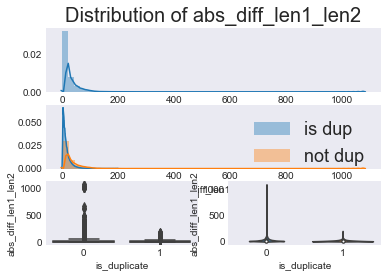

In [5]:
train_df['q1_len'] = train_df['question1'].str.len().astype(np.float32)
train_df['q2_len'] = train_df['question2'].str.len().astype(np.float32)
train_df['abs_diff_len1_len2'] = np.abs(train_df['q1_len'] - train_df['q2_len']).replace(np.nan, 0)
plot_real_feature('abs_diff_len1_len2')

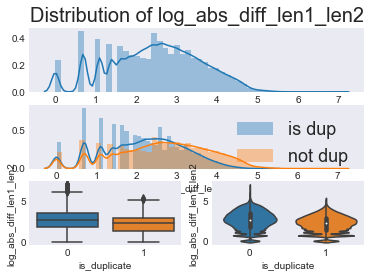

In [6]:
train_df['log_abs_diff_len1_len2'] = np.log(train_df['abs_diff_len1_len2'] + 1)
plot_real_feature('log_abs_diff_len1_len2')

### b. Ratio of  q1 length to q2 length

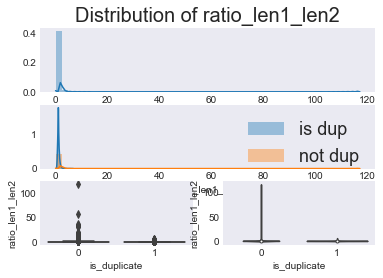

In [7]:
train_df['ratio_len1_len2'] = train_df['q1_len'].apply(lambda x: x if x > 0.0 else 1.0)/\
                        train_df['q2_len'].apply(lambda x: x if x > 0.0 else 1.0)
plot_real_feature('ratio_len1_len2')

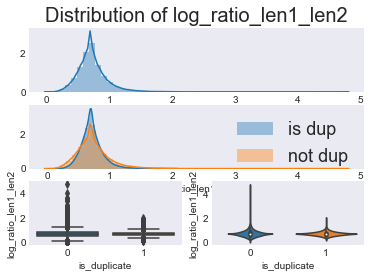

In [8]:
train_df['log_ratio_len1_len2'] = np.log(train_df['ratio_len1_len2'] + 1)
plot_real_feature('log_ratio_len1_len2')

In [9]:
train_df.drop(['abs_diff_len1_len2', 'log_abs_diff_len1_len2', 'ratio_len1_len2', 'log_ratio_len1_len2'], inplace=True, axis=1)
train_df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66.0,57.0


### c. Clean Data

In [10]:
def clean_string(string):
    string = string.lower() \
        .replace("won't", "will not").replace("'ll", " will").replace("cannot", "can not").replace("can't", "can not") \
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
        .replace("'ve", " have").replace("'d", " would").replace("i'm", "i am").replace("'re", " are") \
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ") \
        .replace(",000,000", "m").replace(",000", "k")\
        .replace("=", " equal ").replace("+", " plus ").replace("&", "and").replace("|", "or")\
        .replace("′", "'").replace("’", "'")\
        .replace("e mail", "email").replace("e - mail", "email").replace("e-mail", " email")\
        .replace(" quikly ", " quickly ").replace(" unseccessful ", " unsuccessful ").replace(" insititute ", " institute ")\
        .replace(" programmning ", " programming ").replace(" litrate ", " literate ").replace(" intially ", " initially ")\
        .replace(" demonitization ", " demonetization ").replace(" actived ", " active ").replace(" begineer ", " beginner ")\
        .replace(" connectionn ", " connection ").replace(" permantley ", " permanently ").replace(" litrate ", " literate ")
    string = re.sub('[“”\(\'…\)\!\^\"\.;:,\-\?？\{\}\[\]\\/\*@]', ' ', string)
    return string

    

#  preliminarily clean data for extracting features
def preprocess_df1(df, is_test=False):
    df['question1'] = df['question1'].apply(lambda x : clean_string(str(x)))
    df['question2'] = df['question2'].apply(lambda x : clean_string(str(x)))
    
    if not is_test:
        # discard length less than CUT_SENT_LEN characters
        df['q1_len'] = df['question1'].str.len().astype(np.float32)
        df['q2_len'] = df['question2'].str.len().astype(np.float32)
        indices = set(df[df['q1_len']<CUT_SENT_LEN].index).union(df[df['q2_len']<CUT_SENT_LEN].index)
        df.drop(indices, inplace=True)
        df.reset_index()

        # Can drop the character count columns - to save memory
        df.drop(['q1_len','q2_len'], inplace=True, axis=1)
    return df

In [11]:
train_df = preprocess_df1(train_df)
test_df = preprocess_df1(test_df, is_test=True)
print("preprocess_df1 finished")

preprocess_df1 finished


## II. Extract Features

In [12]:
def common_bigram_count(a, b):
    a = a.split(" ")
    b = b.split(" ")
    a_set = set()
    count = 0
    for pair in zip(a[:-1], a[1:]):
        a_set.add(pair)
    for pair in zip(b[:-1], b[1:]):
        if pair in a_set:
            count += 1
    return count

In [13]:
def common_longest_substring(a, b):
    common_strs = list(distance.lcsubstrings(a, b))
    return 0 if len(common_strs) == 0 else len(common_strs[0])

In [14]:
def nouns_extraction(q1, q2):
    out_list = []
    unigrams_que1 = Extraction().extract_nouns(q1)
    unigrams_que2 = Extraction().extract_nouns(q2)
    common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1)
    return common_unigrams_len, common_unigrams_ratio

In [15]:
def get_features(q1, q2):
    features = {}
    
    is_empty = False

    q1_words = q1.split()
    q2_words = q2.split()

    if len(q1_words) == 0 or len(q2_words) == 0:
        is_empty = True
        
    if not is_empty:
        q1_stops = set([word for word in q1_words if word in STOP_WORDS])
        q2_stops = set([word for word in q2_words if word in STOP_WORDS])

        common_stop_count = len(q1_stops.intersection(q2_stops))
        common_word_count = len(set(q1_words).intersection(set(q2_words)))
        common_noun_info = nouns_extraction(q1, q2)

        min_len = min(len(q1_words), len(q2_words))
        max_len = max(len(q1_words), len(q2_words))

    features["common_stop_ratio_min"] = 0.0 if is_empty else common_stop_count / (min(len(q1_stops), len(q2_stops)) + LAPLACE_ADD)
    features["common_stop_ratio_max"] = 0.0 if is_empty else common_stop_count / (max(len(q1_stops), len(q2_stops)) + LAPLACE_ADD)
    features["common_unigram_ratio_min"] = 0.0 if is_empty else common_word_count / (min_len + LAPLACE_ADD)
    features["common_unigram_ratio_max"] = 0.0 if is_empty else common_word_count / (max_len + LAPLACE_ADD)
    features["common_bigram_ratio_min"] = 0.0 if is_empty else common_bigram_count(q1, q2) / (min_len + LAPLACE_ADD)
    features["common_bigram_ratio_max"] = 0.0 if is_empty else common_bigram_count(q1, q2) / (max_len + LAPLACE_ADD)
    features["common_substring_ratio_min"] = 0.0 if is_empty else common_longest_substring(q1, q2) / (min_len + LAPLACE_ADD)
    features["common_substring_ratro_max"] = 0.0 if is_empty else common_longest_substring(q1, q2) / (max_len + LAPLACE_ADD)
    features["common_noun_count"] = 0.0 if is_empty else common_noun_info[0]
    features["common_noun_ratio"] = 0.0 if is_empty else common_noun_info[1]
    features["is_last_word_equal"] = 0.0 if is_empty else int(q1_words[-1] == q2_words[-1])
    features["is_fisrt_word_equal"] = 0.0 if is_empty else int(q1_words[0] == q2_words[0])
    features["len_diff"] = 0.0 if is_empty else abs(len(q1_words) - len(q2_words))
    features["fuzzy_common_ratio"] = 0.0 if is_empty else fuzz.QRatio(q1, q2)
    features["fuzzy_set_common_ratio"] = 0.0 if is_empty else fuzz.token_set_ratio(q1, q2)
    features["fuzzy_sort_common_ratio"] = 0.0 if is_empty else fuzz.token_set_ratio(q1, q2)
    features["fuzzy_partial_common_ratio"] = 0.0 if is_empty else fuzz.partial_ratio(q1, q2)
    
    NUM_OF_FEATURES = len(features.keys())
    return features

def extract_features(df):
    print("Calculating... (this may take up to several hours)")
    features = df.apply(lambda x: get_features(x["question1"], x["question2"]), axis=1)
    
    for feature in features.iloc[0].keys():
        f = str(feature)
        df[f] = [line[f] for line in features]
        print("Finished extracting " + f)
    return df

def generate_features(df, name, original_num_cols=6):
    df = extract_features(df)
    dfs = np.split(df, [original_num_cols], axis=1)
    dfs[1].to_csv(DATA_PATH + name, index=False) 
    df = dfs[0]

In [16]:
import os
if not os.path.isfile(DATA_PATH + "features_train.csv"):
    print("------------Extracting features in training set---------------")
    generate_features(train_df, "features_train.csv")
    print(str(NUM_OF_FEATURES) + " features have been extracted and saved to features_train.csv")

if not os.path.isfile(DATA_PATH + "features_train.csv"):
    indx = np.linspace(0, len(test_df), 11)
    indx = list(map(lambda x : int(x), indx))
    for i in range(1,11):
        if not os.path.isfile(DATA_PATH + "features_test_part_"+str(i)+".csv"):
            print("Extracting features from test to features_test_part_"+str(i)+".csv")
            generate_features(test_df[indx[i-1]:indx[i]], "features_test_part_"+str(i)+".csv", original_num_cols=3)

## III. Preprocess Data

### a. Embedding Init based on glove

In [17]:
def read_glove_embedding(file_name, embedding_dim):
    embeddings_index = {}
    f = open(file_name, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        if len(values) == embedding_dim + 1:
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    f.close()
    return embeddings_index

In [18]:
embeddings = read_glove_embedding(DATA_PATH+"glove.840B.300d.txt", EMBEDDING_DIM)

In [19]:
top_words = embeddings.keys()

### b. Lemmatization and Process Scarce Words

In [20]:
# lemmatization 词形还原
def cutter_and_replace(word):
    if len(word) >= 4:
        word = WNL.lemmatize(WNL.lemmatize(word, "n"), "v")
    if word in top_words:
        return word
    elif word not in STOP_WORDS:
        return REPLACE_WORD
    return ""

def preprocess_string(string):
    string = ' '.join([cutter_and_replace(w) for w in string.split()])
    return string

# process data
def preprocess_df2(df):
    df['question1'] = df['question1'].apply(lambda x : preprocess_string(str(x)))
    df['question2'] = df['question2'].apply(lambda x : preprocess_string(str(x)))
    return df

In [21]:
train_df = preprocess_df2(train_df)
test_df = preprocess_df2(test_df)
print("preprocess_df2 finished")

preprocess_df2 finished


### c. Tokenize

In [22]:
tokenizer = Tokenizer()
# tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(np.append(train_df['question1'],train_df['question2']))
word_index = tokenizer.word_index
print("tokenizer initialization finished")

tokenizer initialization finished


In [23]:
def tokenize_data(df, tokenizer):
    q1 = pad_sequences(tokenizer.texts_to_sequences(df['question1']), maxlen=MAX_SENT_LEN)
    q2 = pad_sequences(tokenizer.texts_to_sequences(df['question2']), maxlen=MAX_SENT_LEN)
    return q1, q2

In [24]:
train_q1, train_q2 = tokenize_data(train_df, tokenizer)
train_labels = np.array(train_df.is_duplicate)

test_q1, test_q2 = tokenize_data(test_df, tokenizer)
print("tokenize data and get train data labels finished")

tokenize data and get train data labels finished


### d. Create an Embedding Matrix

In [25]:
# Create an embedding matrix containing only the words in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

## III. Model

In [26]:
train_features = pd.read_csv(DATA_PATH + "features_train.csv", encoding ='latin1')
test_features =  pd.read_csv(DATA_PATH + "features_test.csv", encoding ='latin1')

In [27]:
def get_questions_model():
    embedding_layer = Embedding(input_dim=len(word_index)+1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            input_length=MAX_SENT_LEN,
                            trainable=False,
                            mask_zero=False,
                            name='embedding_layer')
    lstm_layer = LSTM(75, recurrent_dropout=0.2)
    question_input_1 = Input(shape=(MAX_SENT_LEN,), dtype="int32")
    embedded_1 = embedding_layer(question_input_1)
    lstm_1 = lstm_layer(embedded_1)

    question_input_2 = Input(shape=(MAX_SENT_LEN,), dtype="int32")
    embedded_2 = embedding_layer(question_input_2)
    lstm_2 = lstm_layer(embedded_2)
    return question_input_1, question_input_2, lstm_1, lstm_2
    


In [28]:
X_train_q1, X_val_q1, X_train_q2, X_val_q2, y_train, y_val, X_train_features, X_val_features =  train_test_split(train_q1,
                                                                                train_q2,
                                                                                train_labels,
                                                                               train_features,
                                                                                random_state=10, 
                                                                                test_size=0.1)

### a. Model without features

In [29]:
def merge_models_no_features(lstm_q1, lstm_q2):
    addition= add([lstm_q1, lstm_q2])
    merged = Dropout(0.4)(addition)

    merged = BatchNormalization()(merged)
    merged = GaussianNoise(0.1)(merged)
    
    merged = Dense(150, activation="relu")(merged)
    merged = Dropout(0.2)(merged)
    merged = BatchNormalization()(merged)
    
    output_layer = Dense(1, activation="sigmoid")(merged)
    return output_layer

def get_model_no_features():
    q1_input, q2_input, lstm_q1, lstm_q2 = get_questions_model()
    output_layer = merge_models_no_features(lstm_q1, lstm_q2)
    
    model = Model(inputs=[q1_input, q2_input], outputs=output_layer)
    return model

In [30]:
def predict_no_features(model):
    # predict and save the results
    preds = model.predict([test_q1, test_q2], batch_size=BATCH_SIZE, verbose=1)

    submission = pd.DataFrame({"test_id": test_df["test_id"], "is_duplicate": preds.ravel()})
    submission.to_csv("preds_no_features.csv", index=False)

In [31]:
model_no_features = get_model_no_features()

model_no_features.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

W0726 14:19:41.157931 193728 deprecation_wrapper.py:119] From C:\Users\h5weng\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 14:19:41.204816 193728 deprecation_wrapper.py:119] From C:\Users\h5weng\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 14:19:41.219777 193728 deprecation_wrapper.py:119] From C:\Users\h5weng\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 14:19:41.238726 193728 deprecation_wrapper.py:119] From C:\Users\h5weng\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please

In [32]:
fit_result_no_features = model_no_features.fit(x = [X_train_q1, X_train_q2], 
                                              y = y_train, 
                                              batch_size=BATCH_SIZE, 
                                              epochs=N_EPOCHS, 
                                              validation_data=([X_val_q1, X_val_q2], y_val))


Train on 363780 samples, validate on 40420 samples
Epoch 1/10
363780/363780 [==============================] - 105s 288us/step - loss: 0.5544 - acc: 0.7159 - val_loss: 0.5188 - val_acc: 0.7412
Epoch 2/10
363780/363780 [==============================] - 103s 283us/step - loss: 0.5008 - acc: 0.7543 - val_loss: 0.5130 - val_acc: 0.7457
Epoch 3/10
363780/363780 [==============================] - 103s 282us/step - loss: 0.4810 - acc: 0.7678 - val_loss: 0.5182 - val_acc: 0.7399
Epoch 4/10
363780/363780 [==============================] - 102s 280us/step - loss: 0.4674 - acc: 0.7775 - val_loss: 0.5728 - val_acc: 0.7185
Epoch 5/10
363780/363780 [==============================] - 102s 281us/step - loss: 0.4553 - acc: 0.7857 - val_loss: 0.5673 - val_acc: 0.7195
Epoch 6/10
363780/363780 [==============================] - 102s 281us/step - loss: 0.4459 - acc: 0.7910 - val_loss: 0.5618 - val_acc: 0.7229
Epoch 7/10
363780/363780 [==============================] - 102s 280us/step - loss: 0.4380 - acc:

In [ ]:
plot_model(model_no_features, to_file='model_no_features.png', show_layer_names=True)
Image('model_no_features.png')

In [34]:
predict_no_features(model_no_features)

2345796/2345796 [==============================] - 192s 82us/step


### b. Model with  Features

In [35]:
def get_features_model(train_features):
    features_input = Input(shape=(train_features.shape[1],), dtype="float32")
    features_dense = BatchNormalization()(features_input)
    features_dense = Dense(200, activation="relu")(features_dense)
    features_dense = Dropout(0.2)(features_dense)
    return features_input, features_dense

In [36]:
def merge_models_with_features(lstm_q1, lstm_q2, features_dense):
    addition= add([lstm_q1, lstm_q2])
    merged = Dropout(0.4)(addition)
    
    merged = concatenate([merged, features_dense])
    merged = BatchNormalization()(merged)
    merged = GaussianNoise(0.1)(merged)
    
    merged = Dense(150, activation="relu")(merged)
    merged = Dropout(0.2)(merged)
    merged = BatchNormalization()(merged)
    
    output_layer = Dense(1, activation="sigmoid")(merged)
    return output_layer

def get_model_with_features(train_features):
    q1_input, q2_input, lstm_q1, lstm_q2 = get_questions_model()
    features_input, features_dense = get_features_model(train_features)
    output_layer = merge_models_with_features(lstm_q1, lstm_q2, features_dense)
    
    model = Model(inputs=[q1_input, q2_input, features_input], outputs=output_layer)
    return model

#### b1. Model with Simple Features

In [37]:
model_with_simfeat = get_model_with_features(train_features.iloc[:,:-4])

model_with_simfeat.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
plot_model(model_with_simfeat, to_file='model_with_simfeat.png', show_layer_names=True)
Image('model_with_simfeat.png')

In [38]:
def predict_with_simfeat(model):
    # predict and save the results
    preds = model.predict([test_q1, test_q2, test_features.iloc[:,:-4]], batch_size=BATCH_SIZE, verbose=1)

    submission = pd.DataFrame({"test_id": test_df["test_id"], "is_duplicate": preds.ravel()})
    submission.to_csv("predict_with_simfeat.csv", index=False)

In [39]:
fit_result_with_simfeat = model_with_simfeat.fit(x = [X_train_q1, X_train_q2, X_train_features.iloc[:,:-4]], 
                                                      y = y_train, 
                                                      batch_size=BATCH_SIZE, 
                                                      epochs=N_EPOCHS, 
                                                      validation_data=([X_val_q1, X_val_q2, X_val_features.iloc[:,:-4]], y_val))


Train on 363780 samples, validate on 40420 samples
Epoch 1/10
363780/363780 [==============================] - 104s 287us/step - loss: 0.4447 - acc: 0.7728 - val_loss: 0.3967 - val_acc: 0.8012
Epoch 2/10
363780/363780 [==============================] - 102s 280us/step - loss: 0.3961 - acc: 0.8052 - val_loss: 0.3767 - val_acc: 0.8155
Epoch 3/10
363780/363780 [==============================] - 101s 278us/step - loss: 0.3777 - acc: 0.8165 - val_loss: 0.3619 - val_acc: 0.8243
Epoch 4/10
363780/363780 [==============================] - 102s 281us/step - loss: 0.3637 - acc: 0.8250 - val_loss: 0.3524 - val_acc: 0.8315
Epoch 5/10
363780/363780 [==============================] - 102s 281us/step - loss: 0.3544 - acc: 0.8317 - val_loss: 0.3489 - val_acc: 0.8347
Epoch 6/10
363780/363780 [==============================] - 103s 283us/step - loss: 0.3460 - acc: 0.8359 - val_loss: 0.3425 - val_acc: 0.8374
Epoch 7/10
363780/363780 [==============================] - 102s 281us/step - loss: 0.3391 - acc:

In [40]:
predict_with_simfeat(model_with_simfeat)

2345796/2345796 [==============================] - 200s 85us/step


#### b2. Model with All Features

In [41]:
model_with_allfeat = get_model_with_features(train_features)

model_with_allfeat.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
plot_model(model_with_allfeat, to_file='model_with_allfeat.png', show_layer_names=True)
Image('model_with_allfeat.png')

In [42]:
def predict_with_allfeat(model):
    # predict and save the results
    preds = model.predict([test_q1, test_q2, test_features], batch_size=BATCH_SIZE, verbose=1)

    submission = pd.DataFrame({"test_id": test_df["test_id"], "is_duplicate": preds.ravel()})
    submission.to_csv("predict_with_allfeat.csv", index=False)

In [43]:
fit_result_with_allfeat = model_with_allfeat.fit(x = [X_train_q1, X_train_q2, X_train_features], 
                                                      y = y_train, 
                                                      batch_size=BATCH_SIZE, 
                                                      epochs=N_EPOCHS, 
                                                      validation_data=([X_val_q1, X_val_q2, X_val_features], y_val))


Train on 363780 samples, validate on 40420 samples
Epoch 1/10
363780/363780 [==============================] - 104s 286us/step - loss: 0.4372 - acc: 0.7776 - val_loss: 0.3894 - val_acc: 0.8053
Epoch 2/10
363780/363780 [==============================] - 103s 284us/step - loss: 0.3879 - acc: 0.8101 - val_loss: 0.3651 - val_acc: 0.8271
Epoch 3/10
363780/363780 [==============================] - 103s 283us/step - loss: 0.3688 - acc: 0.8226 - val_loss: 0.3526 - val_acc: 0.8330
Epoch 4/10
363780/363780 [==============================] - 103s 283us/step - loss: 0.3559 - acc: 0.8301 - val_loss: 0.3466 - val_acc: 0.8374
Epoch 5/10
363780/363780 [==============================] - 103s 284us/step - loss: 0.3456 - acc: 0.8370 - val_loss: 0.3378 - val_acc: 0.8421
Epoch 6/10
363780/363780 [==============================] - 103s 283us/step - loss: 0.3363 - acc: 0.8419 - val_loss: 0.3358 - val_acc: 0.8421
Epoch 7/10
363780/363780 [==============================] - 103s 283us/step - loss: 0.3303 - acc:

In [44]:
predict_with_allfeat(model_with_allfeat)

2345796/2345796 [==============================] - 210s 90us/step


## IV. Result Presentation

In [45]:

def plot_result(r, title, figname):
    fig, ax1 = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)

    data1=r.history["acc"]
    data2=r.history["val_acc"]
    data1l=r.history["loss"]
    data2l=r.history["val_loss"]

    color = "r"
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.plot(data1, c=color, label="Train Accuracy")
    ax1.plot(data2, '--', c=color, label="Validation Accuracy")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=0)

    color2 = "b"
    ax2 = ax1.twinx()  
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.plot(data1l, c=color2, label="Train Loss")
    ax2.plot(data2l, '--', c=color2, label="Validation Loss")
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc=1)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.savefig(figname, format="pdf")
    plt.show()

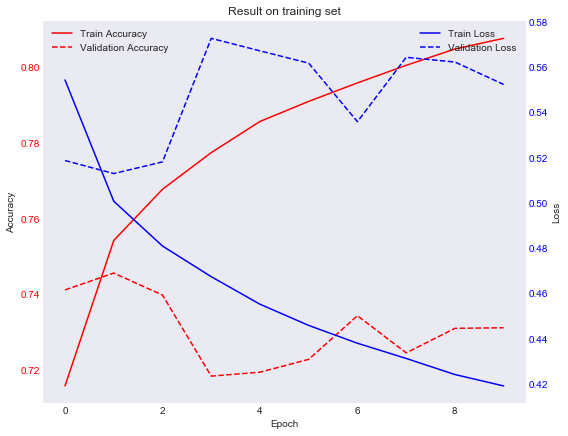

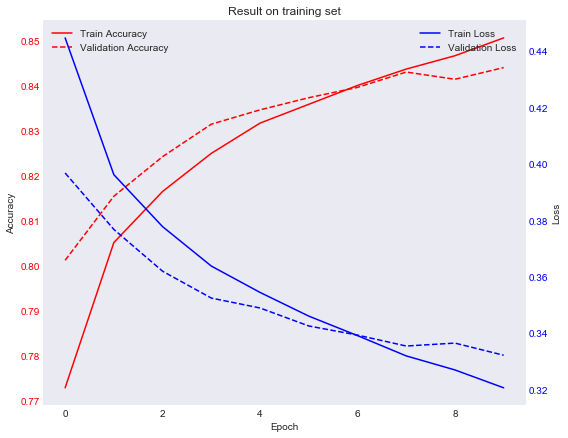

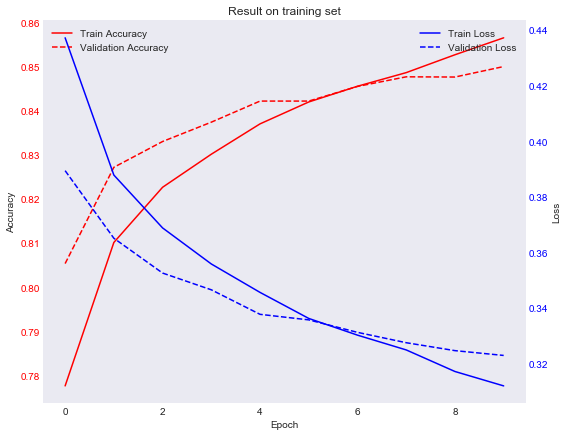

In [46]:
plot_result(fit_result_no_features, "Result on training set", "fit_result_no_features.pdf")
plot_result(fit_result_with_simfeat, "Result on training set", "fit_result_with_simfeat.pdf")
plot_result(fit_result_with_allfeat, "Result on training set", "fit_result_with_allfeat.pdf")